# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [67]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [68]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
import random
import warnings
from IPython.display import display

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

plt.ion()
%matplotlib inline
warnings.filterwarnings('ignore')

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [69]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [70]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [71]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


In [72]:
num_classes = len(np.unique(y))
palette = np.array(sns.color_palette("hls", num_classes))
method = ['PCA', 'KPCA', 'LDA', 'KLDA', 'VGG', 'RESNET', 'RESNET+VGG', 'KPCA+KLDA',  'ALL FEATURES']
datasets = os.listdir('./dataset/')
print(datasets)
indices = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

['IIIT-CFW', 'IMFDB', 'Yale_face_database']


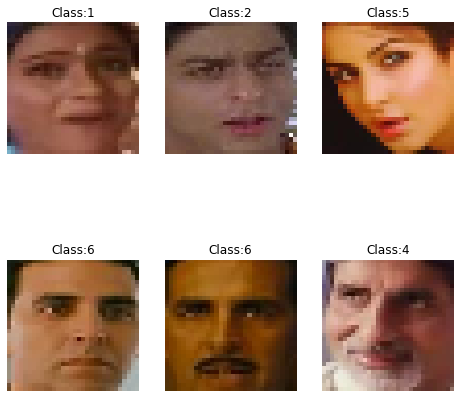

In [73]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [74]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [75]:
def load_dataset(dirpath):
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    return X, y

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [76]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [77]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [78]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [79]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [80]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [81]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

In [82]:
def noeigenvals(X):
    cov_mat = np.cov(X.T)
    eigenval, eigenvec = np.linalg.eig(cov_mat)
    eigenval = np.sort(eigenval)
    eigenval = eigenval[::-1]
    indices = np.where(eigenval.real>1e-1)
    eigenval = eigenval[indices]
    no_eigenvals = eigenval.shape[0]
    return no_eigenvals, eigenval

In [83]:
no_eigenvals = []
eigenval = []
counter = 0
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    val = noeigenvals(X_input)
    no_eigenvals.append(val[0])
    eigenval.append(val[1])
    counter = counter + 1
# print(eigenval[0].shape)
counter = 0

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)
Eigenfaces is the name given to a set of top k eigenvectors when they are used in the computer vision problem of human face recognition.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.

Ans) Number of eigenvectors required depends on what percentage of original data gets represented in the reduced dimension space. If we set a threshold, say we want to capture greater than 90 percent of data for each dataset, then we can make an approximate guess for the number of components required by looking at the plot for cumulative explained variance vs no of components. Eigenspectrum plotted in the below code cells. Cumulative variance vs no of components also plotted below.

In [84]:
# Compute your features 
# eg.
#X_3D = get_kernel_lda(X,y,3)
# X, y = load_dataset('./dataset/IMFDB/')
def return_features(X, y, dirpath, no_eigenvals):
#     print(X.shape)
    X_PCA = get_pca(X, no_eigenvals)
    X_KPCA = get_kernel_pca(X, no_eigenvals, 'rbf')
    X_LDA = get_lda(X, y, 10)
    X_KLDA = get_kernel_lda(X, y, 10)
    X_VGG = get_vgg_features(dirpath)
    X_RESNET = get_resnet_features(dirpath)
    X_RESNET_VGG = np.concatenate((X_RESNET, X_VGG), axis=1)
    X_KPCA_KLDA = np.concatenate((X_KPCA, X_KLDA), axis=1)
    all_tuple = (X_PCA, X_KPCA, X_LDA, X_KLDA, X_VGG, X_RESNET)
    X_ALL = np.concatenate(all_tuple, axis=1)
    features = {
        '0': X_PCA,
        '1': X_KPCA,
        '2': X_LDA,
        '3': X_KLDA,
        '4': X_VGG,
        '5': X_RESNET,
        '6': X_RESNET_VGG,
        '7': X_KPCA_KLDA,
        '8': X_ALL
    }
    return features

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


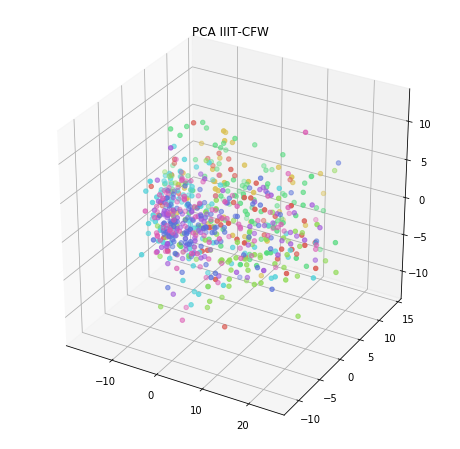

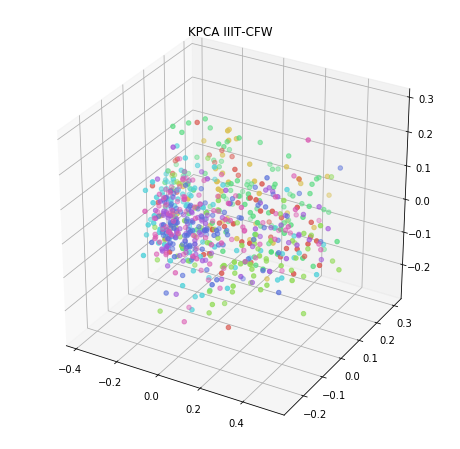

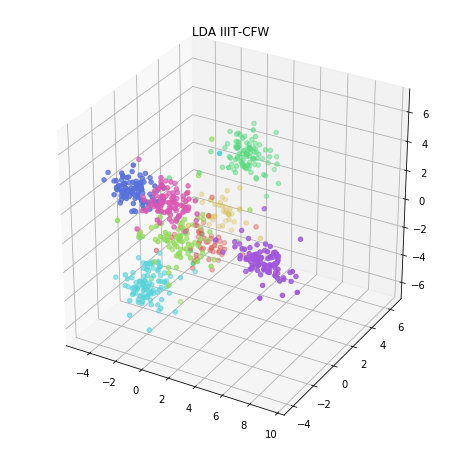

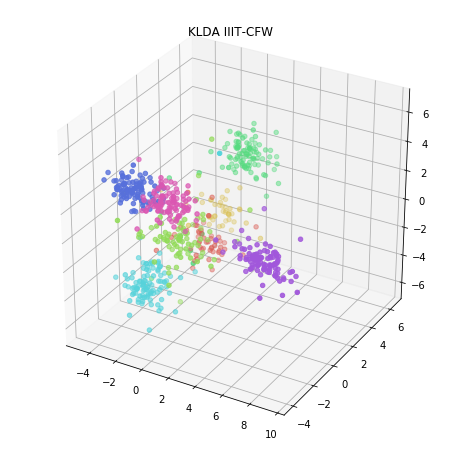

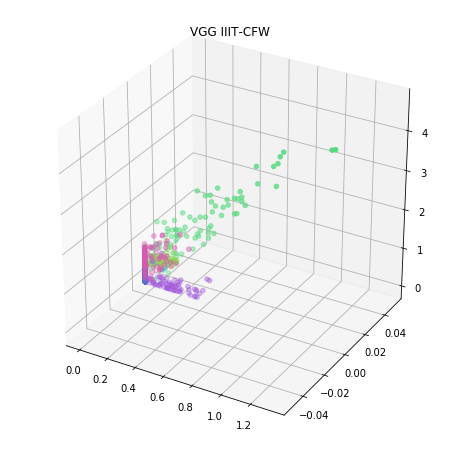

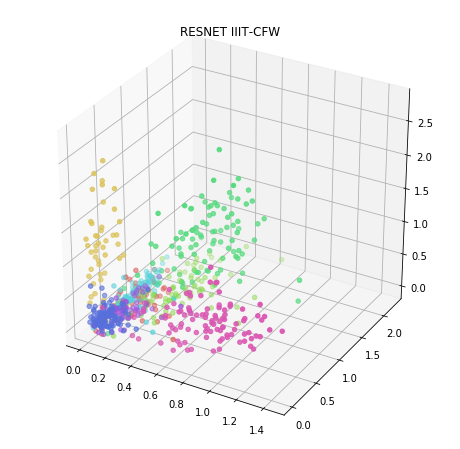

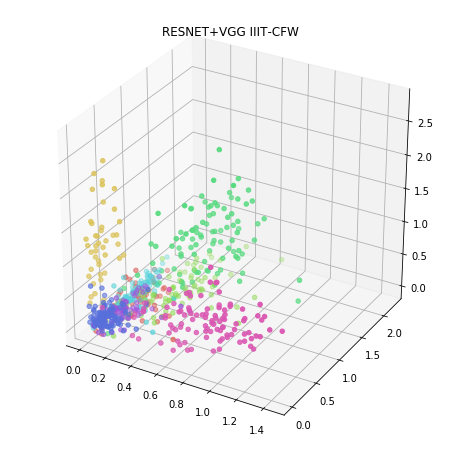

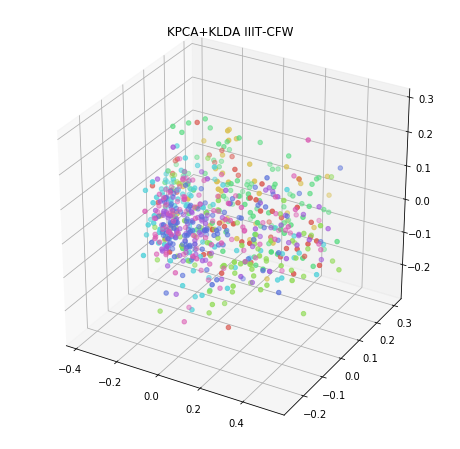

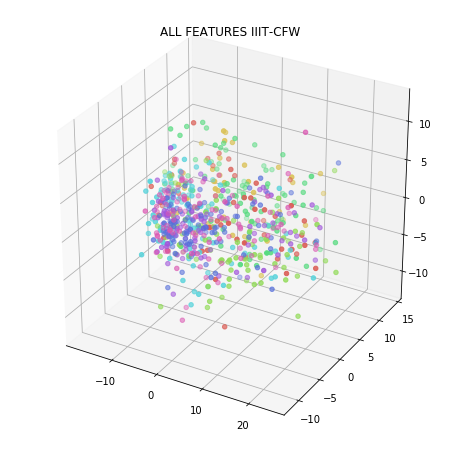

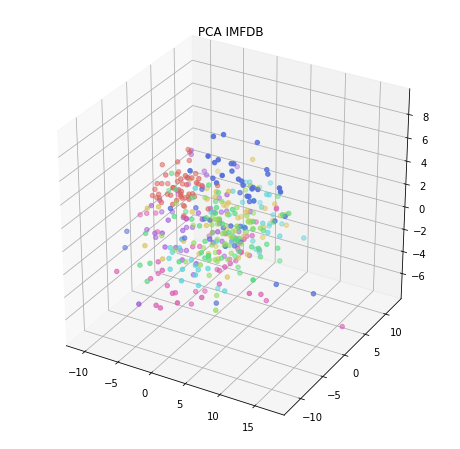

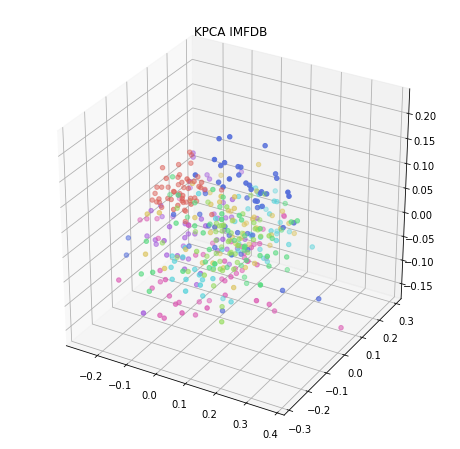

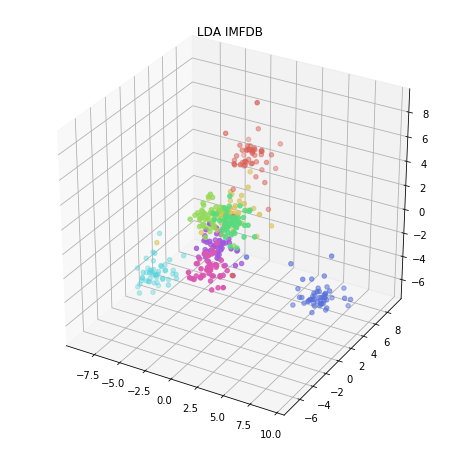

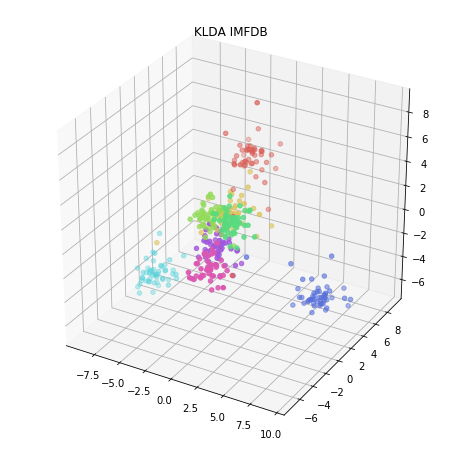

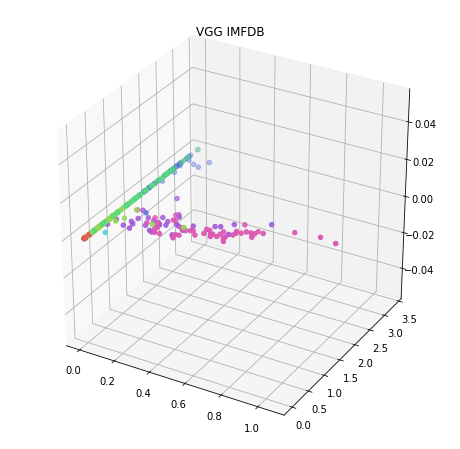

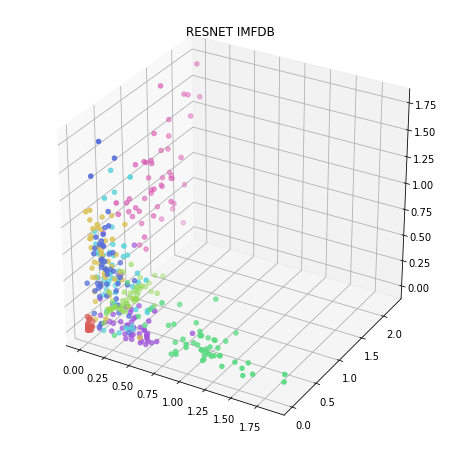

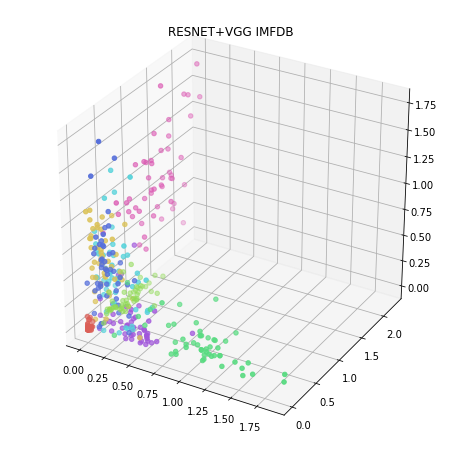

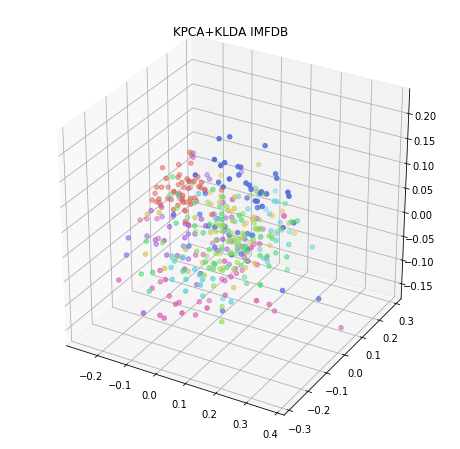

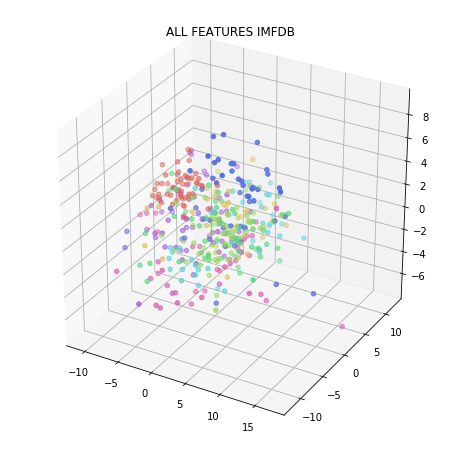

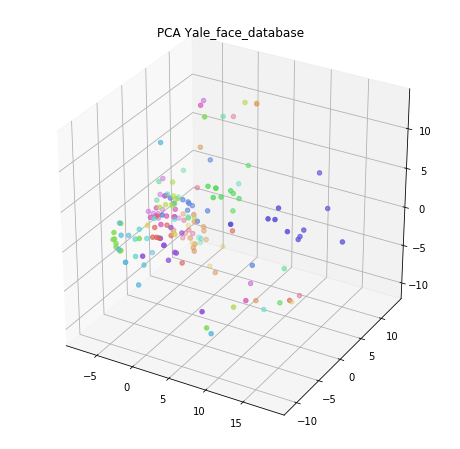

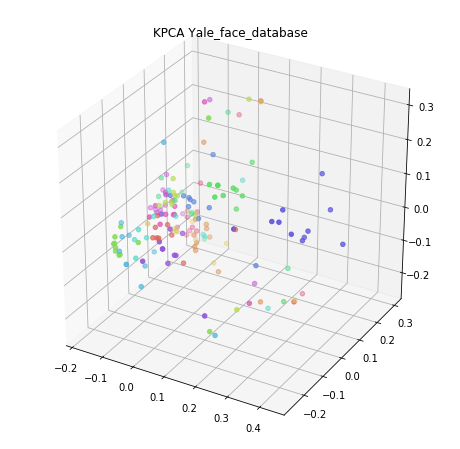

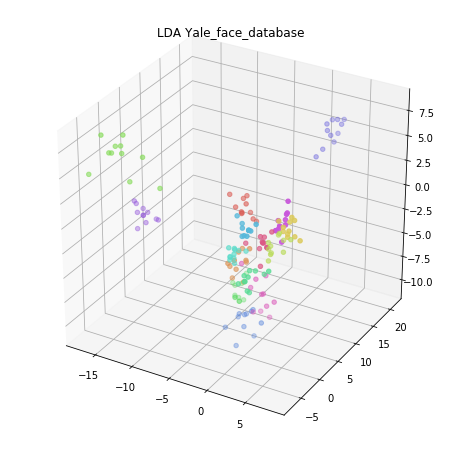

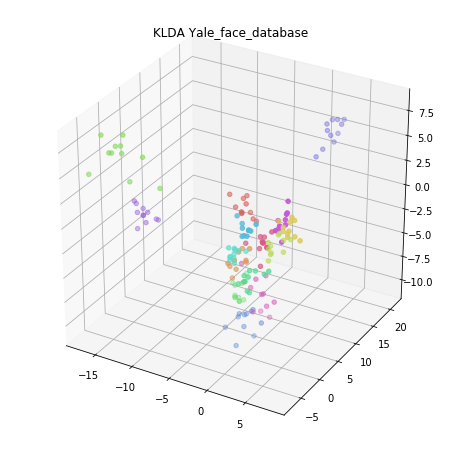

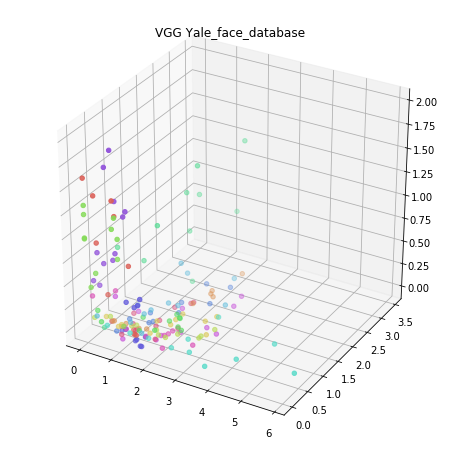

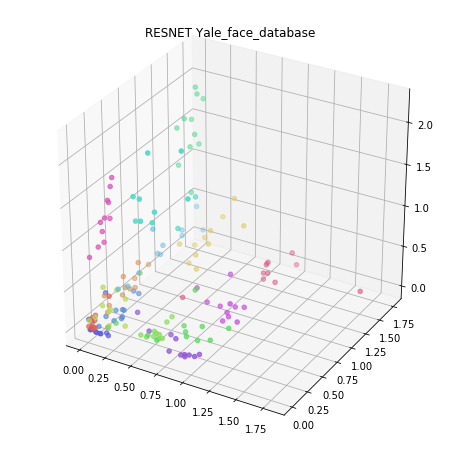

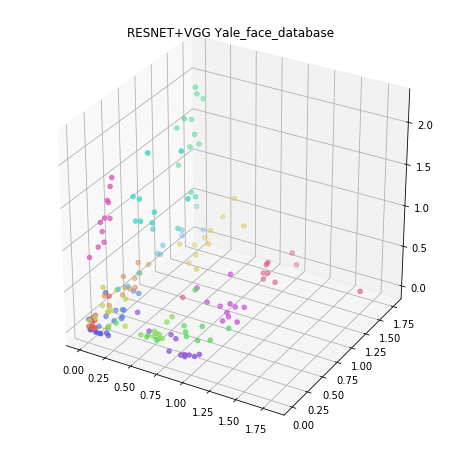

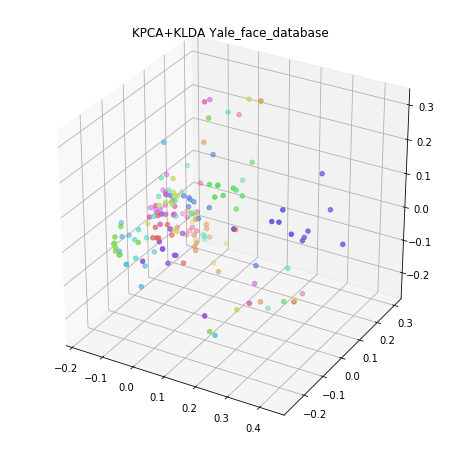

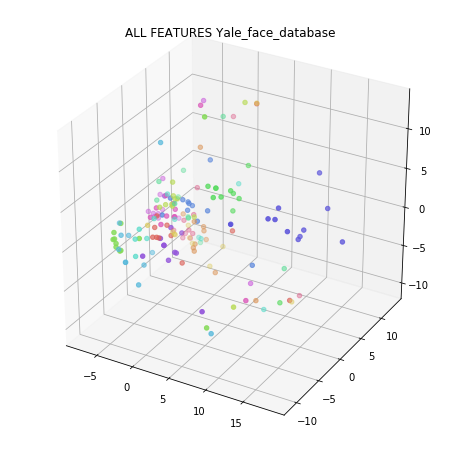

In [85]:
# Create a scatter plot
features = return_features(X, y, dirpath, 100)
#counter = 0
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    for index in feature_input.keys():
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        no_class = len(np.unique(y_input))
        palette = np.array(sns.color_palette("hls", no_class))
        ax.scatter(feature_input[index][:,0],feature_input[index][:,1],feature_input[index][:,2],c=palette[y_input.astype(np.int)])
        ax.set_title(method[int(index)]+' '+data)
        #fig.savefig('a2plots/'+data+'/'+method[int(index)]+'.png')
        #plt.close(fig)

    #counter = counter+1

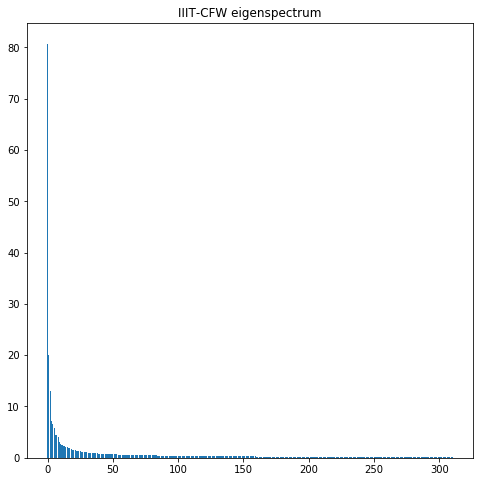

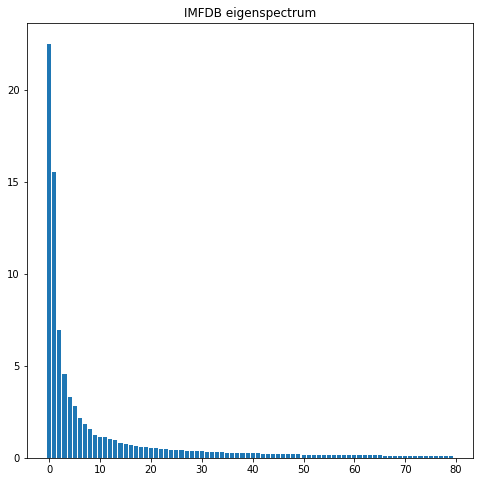

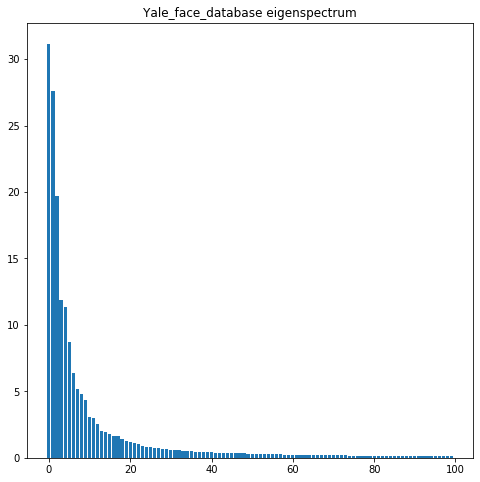

In [86]:
#Plot the eigen value spectrum
counter = 0
for data in datasets:
    plt.figure(figsize=(8, 8))
    plt.title(data+' eigenspectrum')
    plt.bar(np.arange(no_eigenvals[counter]), eigenval[counter].real)
    #plt.savefig('a2plots/'+data+'/eigenspectrum.png')
    #plt.close()
    counter = counter + 1
counter = 0

In [87]:
def reconstruct_pca(*args):
    #X_orig = args[0].reshape((N, H, W, C))
    pca = PCA(n_components=args[1])
    X_fit = pca.fit_transform(args[0])
    X_reconstructed = pca.inverse_transform(X_fit)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    #plt.savefig('a2plots/'+args[2]+'/cum_variance.png')
    #plt.close()
    return X_reconstructed

In [88]:
def reconstruct_kpca(*args):
    kpca = KernelPCA(n_components=args[1],kernel=args[2], gamma=2, degree=args[3] , fit_inverse_transform=True)
    X_k = kpca.fit_transform(args[0])
    X_reconstructed = kpca.inverse_transform(X_k)
    return X_reconstructed

1(c). Reconstruct  the  image  back for each case


In [89]:
def reconstruct_images(choice, *args):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    pass
    reconstruct_X = None
    switcher = {
        0: reconstruct_pca,
        1: reconstruct_kpca
#         2: reconstruct_lda,
#         3: reconstruct_klda,
    }
    func = switcher.get(choice)
    reconstruct_X = func(*args)
    return reconstruct_X    

Dataset shape: (672, 32, 32, 3)
Original Images:


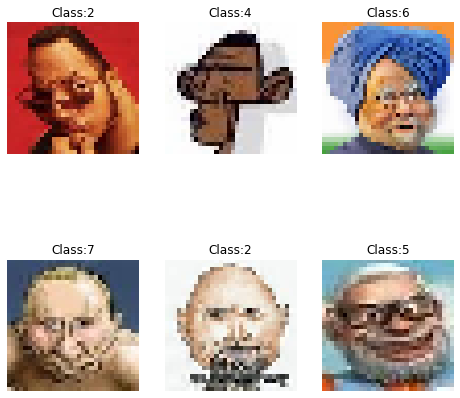

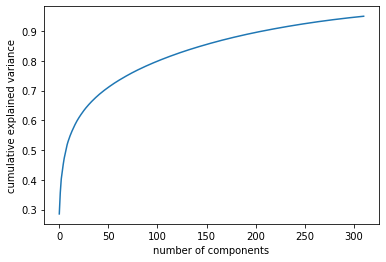

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction errors for: IIIT-CFW
PCA reconstruction error: 0.06767789491569076, KPCA reconstruction error: 0.22208494077334062
Reconstructed images using PCA:


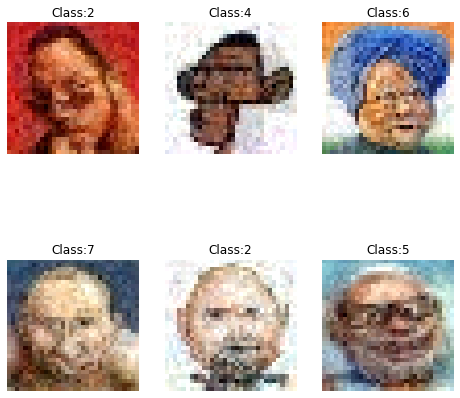

Reconstructed images using KPCA:


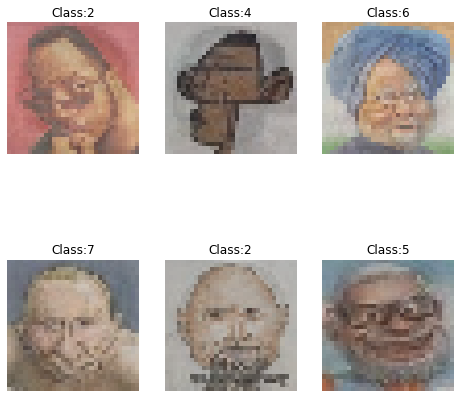

Dataset shape: (400, 32, 32, 3)
Original Images:


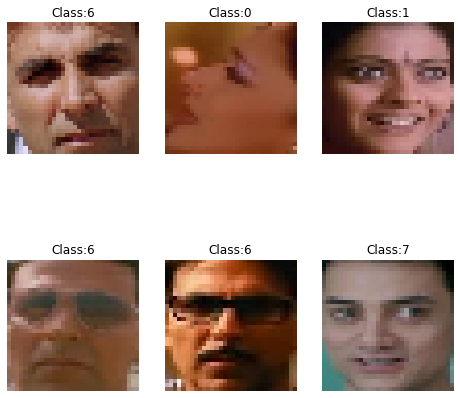

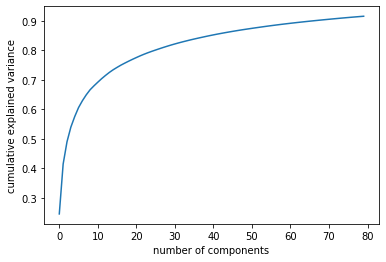

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction errors for: IMFDB
PCA reconstruction error: 0.05017213531728705, KPCA reconstruction error: 0.1475872312045055
Reconstructed images using PCA:


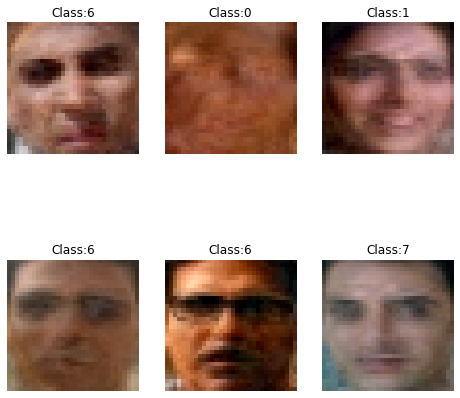

Reconstructed images using KPCA:


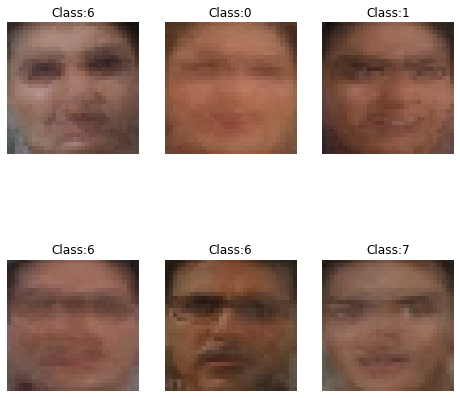

Dataset shape: (165, 32, 32, 3)
Original Images:


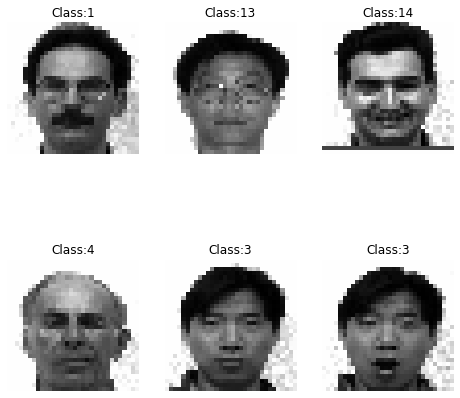

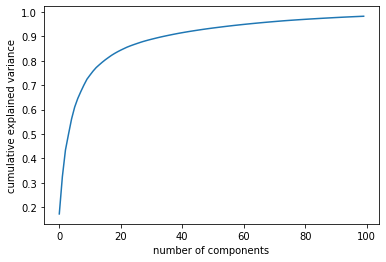

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction errors for: Yale_face_database
PCA reconstruction error: 0.03156356148924875, KPCA reconstruction error: 0.138911781557476
Reconstructed images using PCA:


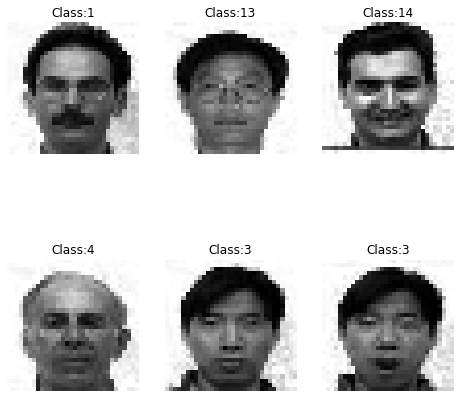

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed images using KPCA:


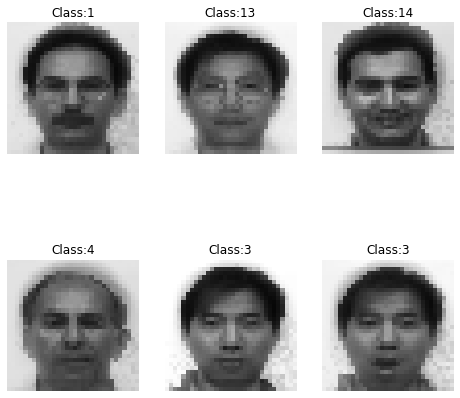

In [90]:
# Display results 
# Original 
counter = 0
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    #feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    ind = np.random.randint(0,y_input.shape[0],6)
    print('Original Images:')
    X_orig = X_input.reshape((X_input.shape[0],32, 32, 3))
    disply_images(X_orig[ind,...],y_input[ind], row=2, col=3)
    
    X_reconstructedPCA = reconstruct_images(0, X_input, no_eigenvals[counter], data)
    #print(no_eigenvals[counter], X_reconstructedPCA.shape)
    X_reconstructedKPCA = reconstruct_images(1, X_input, no_eigenvals[counter], 'rbf', 3)
    # Show the reconstruction error
    print('Reconstruction errors for: '+data)
    print('PCA reconstruction error:', np.sqrt(np.mean((X_input - X_reconstructedPCA)**2)), end=',')
    print(' KPCA reconstruction error:', np.sqrt(np.mean((X_input - X_reconstructedKPCA)**2)))
    # Display random images
    print('Reconstructed images using PCA:')
    X_reconstructed = X_reconstructedPCA.reshape((X_reconstructedPCA.shape[0], 32, 32, 3))
    disply_images(X_reconstructed[ind,...],y_input[ind], row=2, col=3)

    print('Reconstructed images using KPCA:')
    X_reconstructed = X_reconstructedKPCA.reshape((X_reconstructedKPCA.shape[0], 32, 32, 3))
    disply_images(X_reconstructed[ind,...],y_input[ind], row=2, col=3)
    counter = counter + 1

counter = 0

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

Dataset shape: (672, 32, 32, 3)


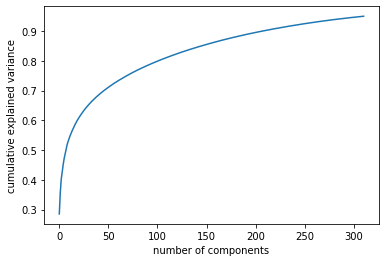

For dataset IIIT-CFW:
4
Class 1 has high pca reconstruction loss
Class 2 has high pca reconstruction loss
Class 3 has high pca reconstruction loss
Class 4 has high pca reconstruction loss
Class 7 has high pca reconstruction loss
Dataset shape: (400, 32, 32, 3)


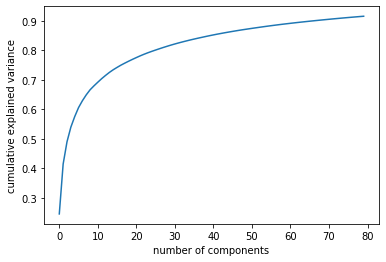

For dataset IMFDB:
3
Class 3 has high pca reconstruction loss
Class 4 has high pca reconstruction loss
Class 6 has high pca reconstruction loss
Dataset shape: (165, 32, 32, 3)


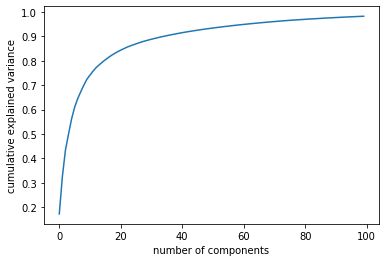

For dataset Yale_face_database:
0
Class 0 has high pca reconstruction loss
Class 3 has high pca reconstruction loss
Class 13 has high pca reconstruction loss


In [91]:
# code goes here
counter = 0
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    #feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    class_number = len(np.unique(y_input))
    pca_error = []
    kpca_error = []
    X_reconstructedPCA = reconstruct_images(0, X_input, no_eigenvals[counter], data)
    X_reconstructedKPCA = reconstruct_images(1, X_input, no_eigenvals[counter], 'rbf', 3)
    for i in range(class_number):
        ith_class = X_input[np.where(y_input==i)]
        ith_class_PCA =  X_reconstructedPCA[y_input==i]
        ith_class_KPCA = X_reconstructedKPCA[y_input==i]
        e1 = np.sqrt(np.mean((ith_class - ith_class_PCA)**2))
        e2 = np.sqrt(np.mean((ith_class - ith_class_KPCA)**2))
        pca_error.append((e1, i))
        kpca_error.append((e2, i))
    
    print('For dataset '+data+':')
    #print(pca_error)
    max_pca = max(pca_error)[0]
    max_kpca = max(kpca_error)[0]
    print(max(pca_error)[1])
    for i in range(class_number):
        if 0.97*max_pca<=pca_error[i][0]:
            print('Class', pca_error[i][1], 'has high pca reconstruction loss')
        
#         if 0.85*max_kpca>=kpca_error[i][0]:
#             print('Class', kpca_error[i][1], 'has high kpca reconstruction loss')
    counter = counter + 1

counter = 0

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [92]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, X, y, classifier_type):
        #super.__init__()
        self.classifier_type = classifier_type
        self.X = X
        self.y = y
        if classifier_type == 'svm':
            self.clf = SVC(gamma='auto', kernel='rbf', C = 1.0)
        elif classifier_type == 'logistic':
            self.clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=300, multi_class='multinomial')
        elif classifier_type == 'mlp':
            self.clf = MLPClassifier(hidden_layer_sizes=(200, 200), solver='adam', alpha=1e-5, random_state=1, learning_rate='adaptive', max_iter=500)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.clf.predict(X)
        return prediction
        
    def confusion_mat(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return confusion_matrix(pred, y)
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_predicted = self.classify(X_validate)
        # Create a confusion matrix
        self.conf_matrix = self.confusion_mat(y_predicted, y_validate)
        #print(confusion_mat)
        
        # Calculate Validation accuracy 
        count = np.count_nonzero(y_predicted == y_validate)
        self.accuracy = ((count/y_test.shape[0])*100)
        
        metrics = precision_recall_fscore_support(y_validate, y_predicted, beta=1.0, average='macro')
        
        # Calculate precision and recall 
        self.precision = metrics[0]
        self.recall = metrics[1]
        
        # Calculate F1-score
        self.f1score = metrics[2]
#         return metrics[2], accuracy

In [93]:
# Create a train and validation split to train your classifier 
feature_space = {'0': 'PCA', 
                 '1': 'KPCA',
                 '2': 'LDA', 
                 '3': 'KLDA', 
                 '4': 'VGG',
                 '5': 'RESNET',
                 '6': 'RESNET+VGG',
                 '7': 'KPCA+KLDA', 
                 '8': 'ALL FEATURES'
                }
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    reduced_space = []
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    print('Results for '+data+':')
    for index in feature_input.keys():
        X_train, X_test, y_train, y_test = train_test_split(feature_input[index], y_input, test_size=0.2, random_state=76)
        print("Feature Space:", feature_space[index])
        index = int(index)

        svm_classifier = Classifier(X, y, 'svm')
        svm_classifier.train(X_train, y_train)
        svm_classifier.validate(X_test, y_test)
        print("svm classifier: ", f'{svm_classifier.accuracy:.2f}', ', ', end="")

        logistic_classifier = Classifier(X, y, 'logistic')
        logistic_classifier.train(X_train, y_train)
        logistic_classifier.validate(X_test, y_test)
        print("logistic classifier: ", f'{logistic_classifier.accuracy:.2f}', ', ', end="")

        mlp_classifier = Classifier(X, y, 'mlp')
        mlp_classifier.train(X_train, y_train)
        mlp_classifier.validate(X_test, y_test)
        print("mlp classifier: ", f'{mlp_classifier.accuracy:.2f}')
        print()

# print 3 classification accuaracies for each of the feature spaces

Dataset shape: (672, 32, 32, 3)
Results for IIIT-CFW:
Feature Space: PCA
svm classifier:  51.11 , logistic classifier:  46.67 , mlp classifier:  60.74

Feature Space: KPCA
svm classifier:  10.37 , logistic classifier:  45.19 , mlp classifier:  48.15

Feature Space: LDA
svm classifier:  97.78 , logistic classifier:  95.56 , mlp classifier:  95.56

Feature Space: KLDA
svm classifier:  97.78 , logistic classifier:  95.56 , mlp classifier:  95.56

Feature Space: VGG
svm classifier:  68.89 , logistic classifier:  74.81 , mlp classifier:  68.89

Feature Space: RESNET
svm classifier:  97.04 , logistic classifier:  97.78 , mlp classifier:  97.04

Feature Space: RESNET+VGG
svm classifier:  98.52 , logistic classifier:  97.78 , mlp classifier:  98.52

Feature Space: KPCA+KLDA
svm classifier:  95.56 , logistic classifier:  95.56 , mlp classifier:  96.30

Feature Space: ALL FEATURES
svm classifier:  99.26 , logistic classifier:  99.26 , mlp classifier:  98.52

Dataset shape: (400, 32, 32, 3)
Resul

In [94]:
df_list = {}
for data in datasets:
    df_list[data] =  pd.DataFrame(columns=['Method', 'Reduced Space', 'Error', 'Accuracy', 'F1-score'], index=indices)

In [95]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
# Print the table. (You can use Pandas)\
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    reduced_space = []
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    for index in indices:
        reduced_space.append(feature_input[index].shape[1])
    #print(data)
    #print(reduced_space)
    for key in feature_input.keys():
        mlp_classifier = Classifier(X_input, y_input, 'mlp')
        #print(feature_input[key].shape[0], y_input.shape)
        X_train, X_test, y_train, y_test = train_test_split(feature_input[key], y_input, test_size=0.2, random_state=76)
        mlp_classifier.train(X_train, y_train)
        mlp_classifier.validate(X_test, y_test)
        #print(a, b)
        index = int(key)
        #print(type(key))
        #print(mlp_classifier.accuracy, mlp_classifier.f1score)
        df_list[data].loc[key] = [ method[index], feature_input[key].shape[1], 100 - mlp_classifier.accuracy, mlp_classifier.accuracy, float(mlp_classifier.f1score)]
    
    print(data+' Dataset:')
    display(df_list[data])

Dataset shape: (672, 32, 32, 3)
IIIT-CFW Dataset:


,Method,Reduced Space,Error,Accuracy,F1-score
0,PCA,100,42.963,57.037,0.553817
1,KPCA,100,51.8519,48.1481,0.460546
2,LDA,7,4.44444,95.5556,0.945718
3,KLDA,7,4.44444,95.5556,0.945718
4,VGG,4096,31.1111,68.8889,0.638534
5,RESNET,2048,2.96296,97.037,0.970851
6,RESNET+VGG,6144,1.48148,98.5185,0.983046
7,KPCA+KLDA,107,3.7037,96.2963,0.95918
8,ALL FEATURES,6358,1.48148,98.5185,0.983046


Dataset shape: (400, 32, 32, 3)
IMFDB Dataset:


,Method,Reduced Space,Error,Accuracy,F1-score
0,PCA,100,18.75,81.25,0.807961
1,KPCA,100,18.75,81.25,0.810381
2,LDA,7,5,95,0.935107
3,KLDA,7,5,95,0.935107
4,VGG,4096,12.5,87.5,0.864513
5,RESNET,2048,3.75,96.25,0.961602
6,RESNET+VGG,6144,0,100,1
7,KPCA+KLDA,107,5,95,0.935107
8,ALL FEATURES,6358,0,100,1


Dataset shape: (165, 32, 32, 3)
Yale_face_database Dataset:


,Method,Reduced Space,Error,Accuracy,F1-score
0,PCA,100,9.09091,90.9091,0.879365
1,KPCA,100,9.09091,90.9091,0.887619
2,LDA,10,0,100,1
3,KLDA,10,0,100,1
4,VGG,4096,48.4848,51.5152,0.49
5,RESNET,2048,0,100,1
6,RESNET+VGG,6144,0,100,1
7,KPCA+KLDA,110,0,100,1
8,ALL FEATURES,6364,0,100,1


In [96]:
# For each dataset print the confusion matrix for the best model 
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    #reduced_space = []
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    df = df_list[data]
    df['F1-score'] = pd.to_numeric(df['F1-score'])
    max_f1score_index = df['F1-score'].idxmax()
    #method = df.loc[max_f1score_index]['Method']
    #print(method)
    mlp_classifier = Classifier(X_input, y_input, 'mlp')
    X_train, X_test, y_train, y_test = train_test_split(feature_input[max_f1score_index], y_input, test_size=0.2, random_state=76)
    mlp_classifier.train(X_train, y_train)
    mlp_classifier.validate(X_test, y_test)
    print(data+' Dataset:')
    print(mlp_classifier.conf_matrix)


Dataset shape: (672, 32, 32, 3)
IIIT-CFW Dataset:
[[14  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0]
 [ 1  0 14  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  1  0 14  0  0  0]
 [ 0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0 20]]
Dataset shape: (400, 32, 32, 3)
IMFDB Dataset:
[[ 7  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0]
 [ 0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0 13]]
Dataset shape: (165, 32, 32, 3)
Yale_face_database Dataset:
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


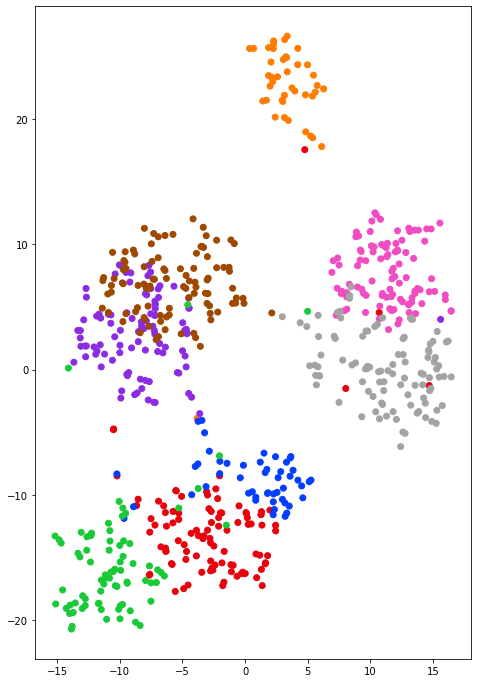

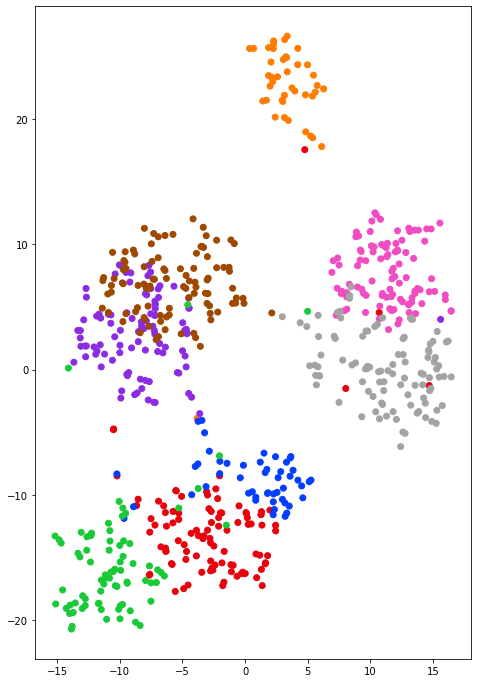

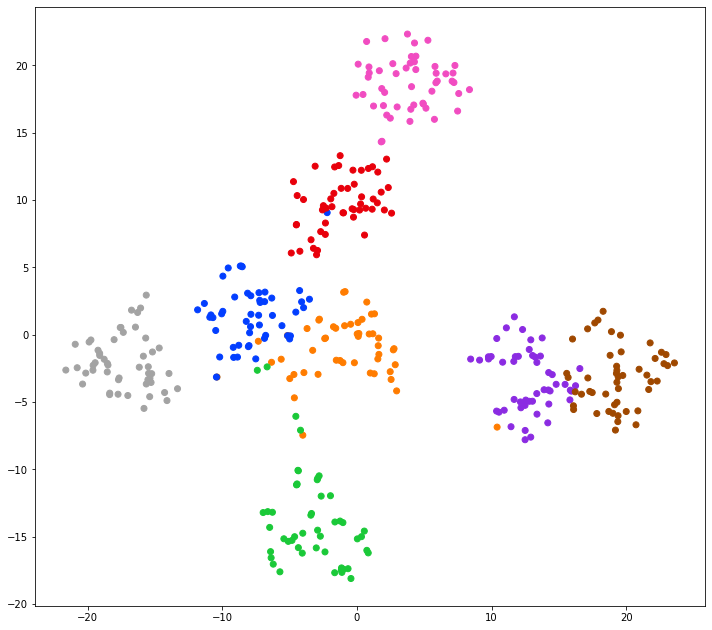

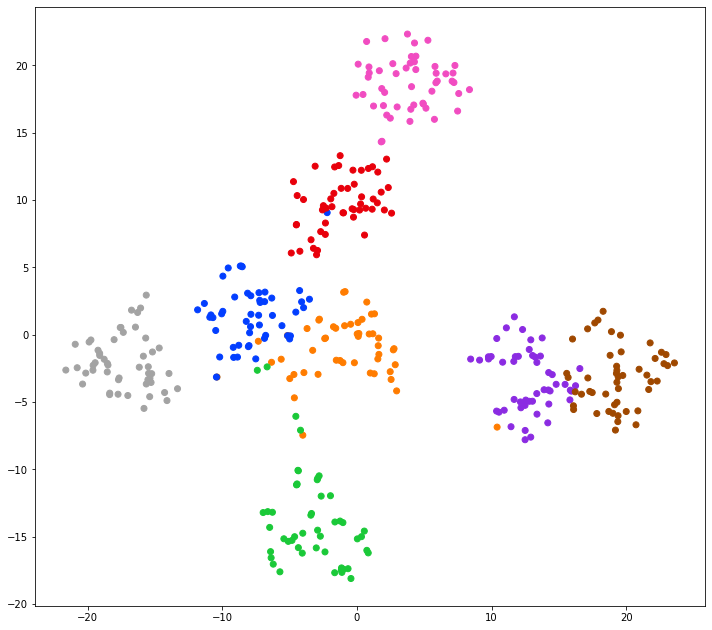

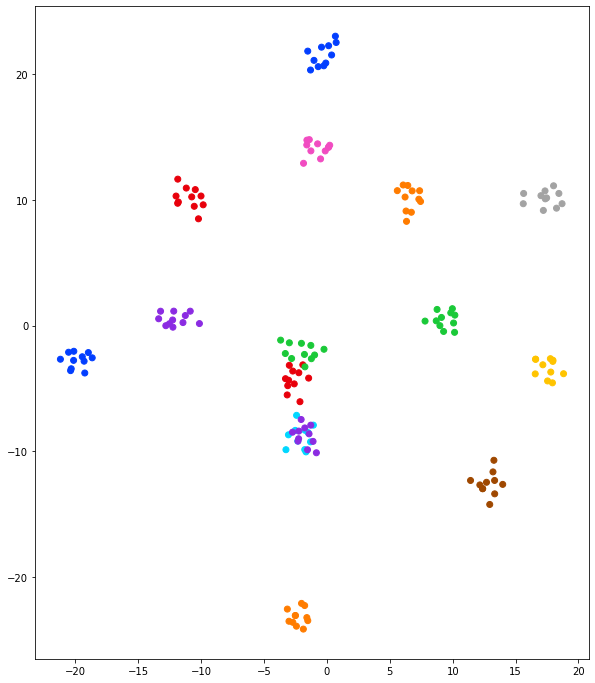

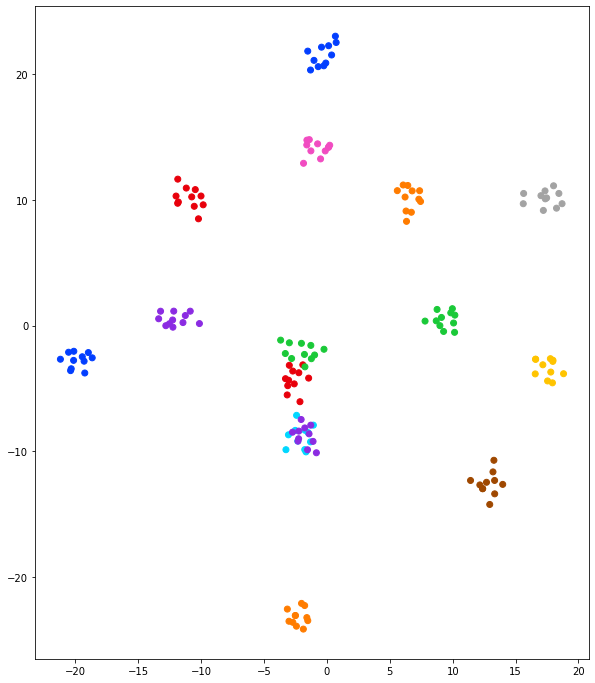

In [97]:
# Compute TSNE for different features and create a scatter plot

#X =  # feature 
k = 3 # Number of components in TSNE

# Compute
for data in datasets:
    X_input, y_input = load_dataset('./dataset/'+data)
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    for index in feature_input.keys():
        if index == '2' or index == '3':
            X_TSNE = TSNE(n_components=k, perplexity=8, learning_rate=10, n_iter=5000, random_state=123).fit_transform(feature_input[index])
            # Plot the representation in 2d/3d
            fig = plt.figure(figsize=(12,12))
            # ax = fig.add_subplot(111, projection='3d')
            ax = plt.subplot(aspect='equal')
            no_class = len(np.unique(y_input))
            palette = np.array(sns.color_palette("bright", no_class))
            ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=palette[y_input.astype(np.int)])
            #fig.savefig('a2plots/TSNE/'+method[int(index)]+'_TSNE_'+data+'.png')
            #plt.close(fig)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [98]:
class FaceVerification():
    def __init__(self, no_neigh):
        #super.__init__()
        self.knn = KNeighborsClassifier(n_neighbors=no_neigh)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X,y_validate):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        predicted = self.knn.predict(X)
        results = np.ones(predicted.shape[0], dtype=bool)
        for i in range(predicted.shape[0]):
            if y_validate[i]!=predicted[i]:
                results[i] = False
        return results
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.knn.fit(X_train, y_train)
        
    def verify(self, X, class_id):
        X = X.reshape((1, X.shape[0]))
        predcited_class = self.knn.predict(X)
        if predcited_class == class_id:
            return True
        return False
    
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        predicted = self.knn.predict(X_validate)
        results = self.classify(X_validate, y_validate)
        metrics = precision_recall_fscore_support(y_validate, predicted, beta=1.0, average='macro')
        #print(results)
        self.accuracy = (np.count_nonzero(results==True)/results.shape[0])*100
        #print(self.accuracy)
        self.precision = metrics[0]
        return results

Dataset shape: (672, 32, 32, 3)


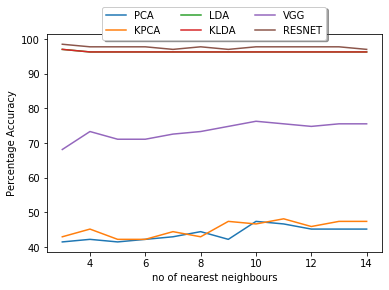

Dataset shape: (400, 32, 32, 3)


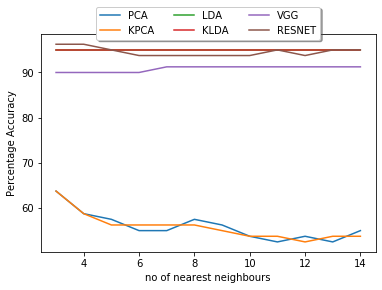

Dataset shape: (165, 32, 32, 3)


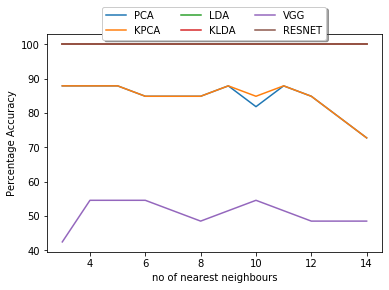

In [99]:
## Create a train and validation split and show your results
for data in datasets:
    #fig, ax = plt.subplots()
    #ax.set_xlim([0,15])
    X_input, y_input = load_dataset('./dataset/'+data)
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    for index in feature_input.keys():
        X_train, X_test, y_train, y_test = train_test_split(feature_input[index], y_input, test_size=0.2, random_state=76)
        knn_accuracies = []
        for no_neigh in range(3, 15):
            knn_classifier = FaceVerification(no_neigh)
            knn_classifier.train(X_train, y_train)
            results = knn_classifier.validate(X_test, y_test)
            #knn_acc = np.count_nonzero(results==True)
            #Accuray for knn
            knn_accuracies.append(knn_classifier.accuracy)
            #print('Accuracy for ' + method[int(index)] + '+KNN: ', (knn_acc/results.shape[0])*100)
        #print(knn_accuracies)
        plt.plot(range(3, 15), knn_accuracies, label=method[int(index)])
        if index=='5':
            break
    plt.xlabel('no of nearest neighbours')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
    plt.ylabel('Percentage Accuracy')
    plt.title(data)
    #plt.savefig('a2plots/KNN/'+'knn_'+data+'.png')
    plt.show()
    #plt.close()

In [100]:
df_list1 = {}
for data in datasets:
    df_list1[data] =  pd.DataFrame(columns=['Method', 'Reduced Space', 'Verification Error', 'Accuracy', 'Precision'], index=indices)

In [101]:
# Emperical results for KLDA feature space
knn_classifier = FaceVerification(3)
X_train, X_test, y_train, y_test = train_test_split(features['2'], y, test_size=0.2, random_state=76)
knn_classifier.train(X_train, y_train)
ind = np.random.randint(0,y.shape[0],6)
for index in ind:
    #print(features['2'][index])
    response = knn_classifier.verify(features['2'][index], y[index])
    if response:
        print('Yes')
    else:
        print('No')

Yes
Yes
Yes
Yes
Yes
Yes


In [102]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
for data in datasets:
    #data = 'IMFDB'
    X_input, y_input = load_dataset('./dataset/'+data)
    reduced_space = []
    feature_input = return_features(X_input, y_input, './dataset/'+data, 100)
    
    for index in indices:
        reduced_space.append(feature_input[index].shape[1])
        
    for key in feature_input.keys():
        knn = FaceVerification(3)
        X_train, X_test, y_train, y_test = train_test_split(feature_input[key], y_input, test_size=0.2, random_state=76)
        knn.train(X_train, y_train)
        knn.validate(X_test, y_test)
        index = int(key)
        df_list1[data].loc[key] = [ method[index], feature_input[key].shape[1], 100 - knn.accuracy, knn.accuracy, float(knn.precision)]
    
    print(data+' Dataset:')
    display(df_list1[data])
# Print the table. (You can use Pandas)

Dataset shape: (672, 32, 32, 3)
IIIT-CFW Dataset:


,Method,Reduced Space,Verification Error,Accuracy,Precision
0,PCA,100,59.2593,40.7407,0.526176
1,KPCA,100,57.037,42.963,0.529365
2,LDA,7,2.96296,97.037,0.97197
3,KLDA,7,2.96296,97.037,0.97197
4,VGG,4096,31.8519,68.1481,0.625551
5,RESNET,2048,1.48148,98.5185,0.985714
6,RESNET+VGG,6144,0.740741,99.2593,0.991667
7,KPCA+KLDA,107,2.96296,97.037,0.97197
8,ALL FEATURES,6358,0.740741,99.2593,0.992188


Dataset shape: (400, 32, 32, 3)
IMFDB Dataset:


,Method,Reduced Space,Verification Error,Accuracy,Precision
0,PCA,100,36.25,63.75,0.73398
1,KPCA,100,36.25,63.75,0.74023
2,LDA,7,5,95,0.946825
3,KLDA,7,5,95,0.946825
4,VGG,4096,10,90,0.9
5,RESNET,2048,3.75,96.25,0.96875
6,RESNET+VGG,6144,3.75,96.25,0.959722
7,KPCA+KLDA,107,5,95,0.946825
8,ALL FEATURES,6358,1.25,98.75,0.9875


Dataset shape: (165, 32, 32, 3)
Yale_face_database Dataset:


,Method,Reduced Space,Verification Error,Accuracy,Precision
0,PCA,100,12.1212,87.8788,0.923333
1,KPCA,100,12.1212,87.8788,0.923333
2,LDA,10,0,100,1
3,KLDA,10,0,100,1
4,VGG,4096,57.5758,42.4242,0.427381
5,RESNET,2048,0,100,1
6,RESNET+VGG,6144,6.06061,93.9394,0.961111
7,KPCA+KLDA,110,0,100,1
8,ALL FEATURES,6364,0,100,1


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [103]:
# Load data
# def load_emodata(dir_path):
#     image_list = []
#     y_list = []
    
#     if "CFW" in dir_path:
#         label_dict = cfw_dict

#     elif "yale" in dir_path.lower():
#         label_dict = {}
#         for i in range(11):
#             label_dict[str(i)] = i
#     elif "IMFDB" in dir_path:
#         label_dict = imfdb_dict
#     else:
#         raise KeyError("Dataset not found.")
    
    
#     for filename in sorted(os.listdir(dir_path)):
#         if filename.endswith(".png"):
#             im = load_image(os.path.join(dir_path,filename))
#             y = filename.split('_')[1].split('.')[0]
#             y = label_dict[y] 
#             #print(filename, y)
#             image_list.append(im)
#             y_list.append(y)
#         else:
#             continue

#     image_list = np.array(image_list)
#     y_list = np.array(y_list)

#     print("Dataset shape:", image_list.shape)

#     return image_list,y_list
def get_data_with_emotions(dir_path):
    image_list = []
    y_list = []
    
    if "yale" in dir_path.lower():
        emotions = pd.read_csv('./dataset/Yale_face_database/emotiom.txt',header=None)
    elif "IMFDB" in dir_path:
        emotions = pd.read_csv('./dataset/IMFDB/emotion.txt',header=None)
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = emotions.loc[emotions[0] == filename].iloc[0,1]
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list


In [104]:
def get_input(dirpath):
    X_final,emotions = get_data_with_emotions(dirpath)
    N,H,W = X_final.shape[0:3]
    C = 1 if opt['is_grayscale'] else X_final.shape[3]
    X_final = np.reshape(X_final,(N,(H*W*C)))
    em_unique = list(set(emotions))
    y_final = np.array([em_unique.index(em) for em in emotions])
    return X_final, y_final, emotions, em_unique

In [105]:
dirpath = './dataset/Yale_face_database/'
dirpath1 = './dataset/IMFDB/'
X_final, y_final, emotions, em_unique = get_input('./dataset/Yale_face_database/')
X_final1, y_final1, emotions1, em_unique1 = get_input('./dataset/IMFDB/')

Dataset shape: (165, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)


In [106]:
# Define your features

features_emo = return_features(X_final, y_final, dirpath, 100)
features_emo1 = return_features(X_final1, y_final1, dirpath1, 100)

In [107]:
class mlp_mod(MLPClassifier):
    def _init_coef(self, fan_in, fan_out):
        init_bound = np.sqrt(2. / (fan_in + fan_out))
        coef_init = self._random_state.uniform(-init_bound, init_bound,
                                               (fan_in, fan_out))
        coef_init = np.random.normal(0,1,(fan_in, fan_out)) / np.sqrt(fan_in+fan_out)
        intercept_init = self._random_state.uniform(-init_bound, init_bound,
                                                    fan_out)
        intercept_init = np.random.normal(0,1,fan_out)/np.sqrt(fan_out)
        return coef_init, intercept_init


In [108]:
def return_classifier(features_emo, y_final):
    classifier = mlp_mod(alpha= 1e-3,learning_rate= 'adaptive',solver='adam',epsilon = 1, beta_1 = 0.2,beta_2 =0.2, hidden_layer_sizes=(100, 200, 100),max_iter = 5000, verbose=False, tol=1e-5, activation='relu')
    # Validate your classifier
    X_train, X_test, y_train, y_test = train_test_split(features_emo['2'],y_final,test_size = 0.2, random_state = 76)
    classifier.fit(X_train,y_train)
    predicter = classifier.predict(X_test)
    counting = np.count_nonzero(y_test == predicter)
    class_acc = ((counting/y_test.shape[0])*100)
    print('Testing accuracy: ', class_acc)

    predicter = classifier.predict(X_train)
    counting = np.count_nonzero(y_train == predicter)
    class_acc = ((counting/y_train.shape[0])*100)
    print('Training accuracy: ', class_acc)
    return classifier

In [109]:
classifier = return_classifier(features_emo, y_final)
classifier1 = return_classifier(features_emo1, y_final1)

Testing accuracy:  87.87878787878788
Training accuracy:  92.42424242424242
Testing accuracy:  90.0
Training accuracy:  94.6875


In [110]:
Cross_valid_acc = np.mean(cross_val_score(classifier, features_emo['2'], y_final, cv=5))*100
print('Cross K-Fold Accuracy with k =5: for Yale dataset', Cross_valid_acc)
Cross_valid_acc1 = np.mean(cross_val_score(classifier1, features_emo1['2'], y_final1, cv=5))*100
print('Cross K-Fold Accuracy with k =5: for IMFDB dataset', Cross_valid_acc1)

Cross K-Fold Accuracy with k =5: for Yale dataset 91.51515151515153
Cross K-Fold Accuracy with k =5: for IMFDB dataset 93.98254831588166


In [111]:
def t_SNE(features_emo, y_final, dirpath):
    X_TSNE = TSNE(n_components=2).fit_transform(features_emo['2'])
    fig = plt.figure(figsize=(8,8))
    # ax = fig.add_subplot(111, projection='3d')
    ax = plt.subplot(aspect='equal')
    no_class = len(np.unique(y_final))
    palette = np.array(sns.color_palette("hls", no_class))
    # print(no_class)
    ax.set_title('t-SNE')
    ax.scatter(X_TSNE[:,0], X_TSNE[:,1], c=palette[y_final.astype(np.int)])
    #fig.savefig(dirpath+'TSNE.png')
    #plt.close(fig)


In [112]:
def pca(features_emo, y_final, dirpath):
    X_PCA = get_pca(features_emo['2'],2)
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(aspect='equal')
    ax.scatter(X_PCA[:,0],X_PCA[:,1],c=palette[y_final.astype(np.int)])
    ax.set_title('PCA')
    #fig.savefig(dirpath+'PCA.png')
    #plt.close(fig)

In [113]:
def isomap(features_emo, y_final, dirpath):
    embedding = Isomap(n_components=2, n_neighbors=4)
    X_trans = embedding.fit_transform(features_emo['2'])
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(aspect='equal')
    ax.scatter(X_trans[:,0],X_trans[:,1],c=palette[y_final.astype(np.int)])
    ax.set_title('Isompap')
    #fig.savefig(dirpath+'Isomap.png')
    #plt.close(fig)

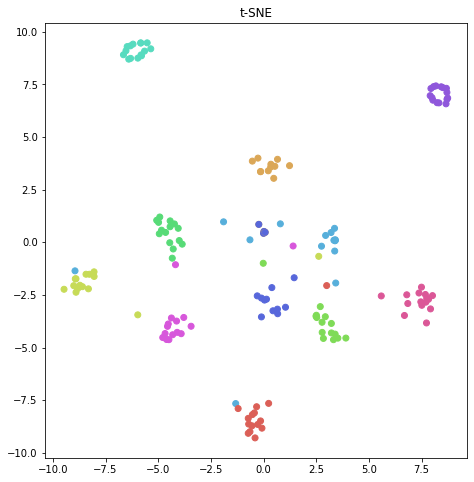

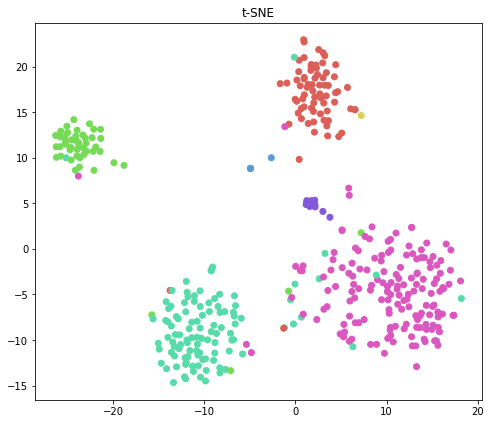

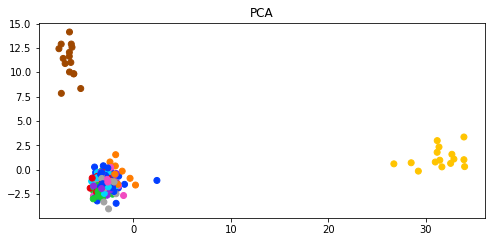

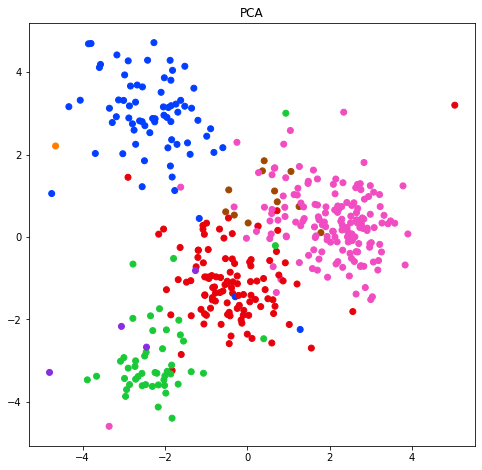

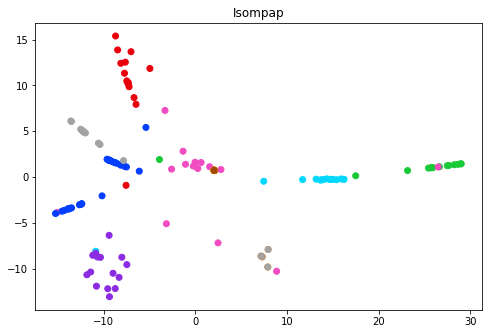

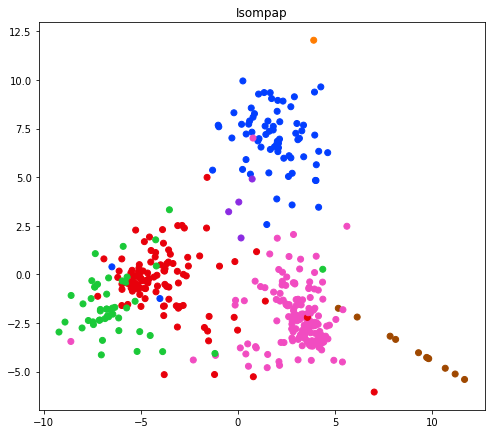

In [114]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
# tf

#TSNE plot
t_SNE(features_emo, y_final, './q21_plots')
t_SNE(features_emo1, y_final1, './q22_plots')
#PCA plot
pca(features_emo, y_final, './q21_plots')
pca(features_emo1, y_final1, './q22_plots')
#Isomaps plot
isomap(features_emo, y_final, './q21_plots')
isomap(features_emo1, y_final1, './q22_plots')

[ 14 154  93  95 103   3]
[ 0 10  1  5  8  0] [ 0 10  1  5  8  0]
Correct Prediction: happy
Correct Prediction: centerlight
Correct Prediction: noglasses
Correct Prediction: rightlight
Correct Prediction: leftlight
Correct Prediction: happy


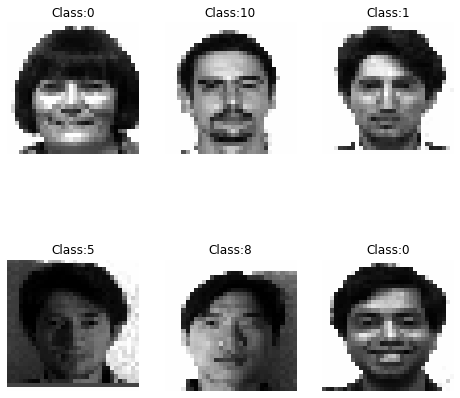

leftlight


In [115]:
# Show quantitative results such as examples of correct prediction and wrong prediction
ind = np.random.randint(0,y_final.shape[0],6)
print(ind)
# Original images
pred_labels = classifier.predict(features_emo['2'][ind])
truth_labels = y_final[ind]
#print(em_unique)
print(pred_labels, truth_labels)
for j in range(6):
    if pred_labels[j]!=truth_labels[j]:
        print('Wrong Prediction:', em_unique[pred_labels[j]], ',Correct Answer:', em_unique[truth_labels[j]])
    else:
        print('Correct Prediction:', em_unique[truth_labels[j]])

X_4dim = X_final.reshape((X_final.shape[0], 32, 32, 3))
disply_images(X_4dim[ind,...],y_final[ind], row=2, col=3)
print(em_unique[8])

[305 127 205 386 259  17]
['DISGUST', 'FEAR', 'SADNESS', 'NEUTRAL', 'ANGER', 'SURPRISE', 'HAPPINESS']
[3 3 6 3 6 3] [3 3 6 3 6 3]
Correct Prediction: NEUTRAL
Correct Prediction: NEUTRAL
Correct Prediction: HAPPINESS
Correct Prediction: NEUTRAL
Correct Prediction: HAPPINESS
Correct Prediction: NEUTRAL


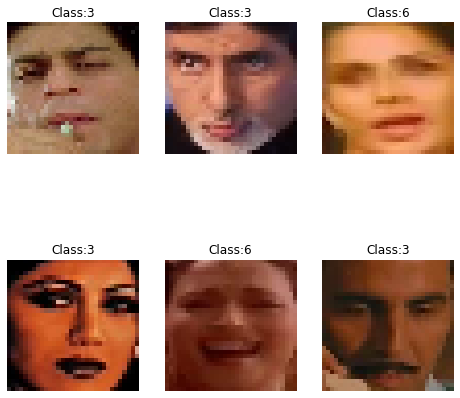

In [116]:
# Show quantitative results such as examples of correct prediction and wrong prediction
ind = np.random.randint(0,y_final1.shape[0],6)
print(ind)
# Original images
pred_labels = classifier1.predict(features_emo1['2'][ind])
truth_labels = y_final1[ind]
print(em_unique1)
print(pred_labels, truth_labels)
for j in range(6):
    if pred_labels[j]!=truth_labels[j]:
        print('Wrong Prediction:', em_unique1[pred_labels[j]], ',Correct Answer:', em_unique1[truth_labels[j]])
    else:
        print('Correct Prediction:', em_unique1[truth_labels[j]])

X_4dim = X_final1.reshape((X_final1.shape[0], 32, 32, 3))
disply_images(X_4dim[ind,...],y_final1[ind], row=2, col=3)